In this notebook, we'll learn how to convert multiple Front-facing images to Birds Eye View (BEV) using Deep Learning Approaches

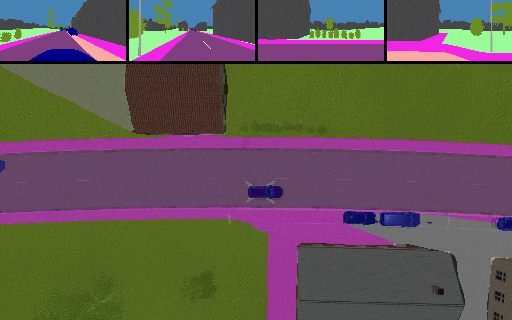

## Imports

In [1]:
!pip install torchgeometry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 2.6 MB/s eta 0:00:00


In [2]:
import os
import sys
import cv2
import numpy as np
sys.path.append('/kaggle/input/cam2bev-frlr/cam2bev-data-master')
import matplotlib.pyplot as plt

## DL imports
import torch
import torch.nn as nn

## Cam2BEV dataset
We'll be using the [Cam2BEV dataset](https://gitlab.ika.rwth-aachen.de/cam2bev/cam2bev-data) from [Sim2Real paper](https://browse.arxiv.org/pdf/2005.04078.pdf). It consists of Semantically Segmented images from Front, Rear, Left and Right cameras and corresponding BEV images.

In [3]:
dataRootDir = '/kaggle/input/cam2bev-frlr/cam2bev-data-master/1_FRLR'
trainDir = os.path.join(dataRootDir, *['train'])
valDir = os.path.join(dataRootDir, *['val'])
examplesDir = os.path.join(dataRootDir, *['examples'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_image(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

frontImg = load_image(os.path.join(examplesDir, *['front.png']))
leftImg = load_image(os.path.join(examplesDir, *['left.png']))
rearImg = load_image(os.path.join(examplesDir, *['rear.png']))
rightImg = load_image(os.path.join(examplesDir, *['right.png']))
bevImg = load_image(os.path.join(examplesDir, *['bev.png']))
bevOccImg = load_image(os.path.join(examplesDir, *['bev+occlusion.png']))

print(frontImg.shape)

(604, 964, 3)


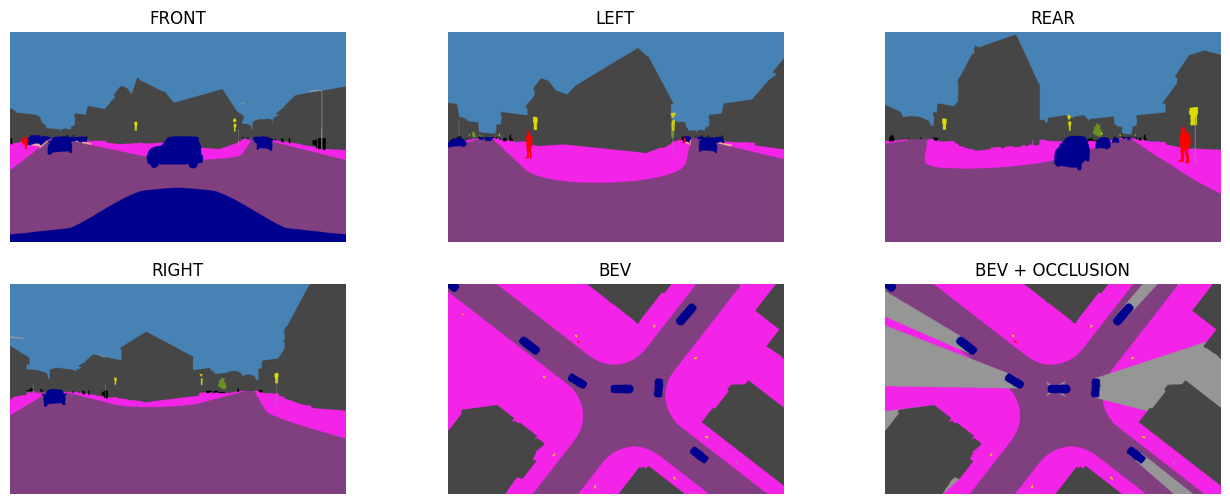

In [4]:
imageList = [frontImg, leftImg, rearImg, rightImg, bevImg, bevOccImg]
titlesList = ['FRONT', 'LEFT', 'REAR', 'RIGHT', 'BEV', 'BEV + OCCLUSION']

# function to plot single image
def plotImage(ax, img, title):
    imgHandle = ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
    return imgHandle

fig, axes = plt.subplots(2,3, figsize= (16, 6))
for (ax,img,title) in zip(axes.flatten(), imageList, titlesList):
    plotImage(ax, img, title)
plt.show()

The colors on the image correspond to 30 classes in [Cityscapes dataset](https://www.cityscapes-dataset.com/). We'll need to convert the RGB image to One-hot encoded image. We'll need a color -> Class mapping which is defined as follows. 
- For the Input image, we'll group 30 classes to 10 classes 
- For the Output image, we'll group 30 classes to 10 classes (including **Occlusion as the 10th class**)

In [5]:
inputPalette = [
    [np.array([128,  64, 128])],                                                       # road  
    [np.array([244,  35, 232]), np.array([250, 170, 160])],                            # sidewalk
    [np.array([255,   0,   0])],                                                       # person   
    [np.array([  0,   0, 142]), np.array([  0,   0, 110])],                            # car
    [np.array([ 0,  0, 70])],                                                          # Truck
    [np.array([  0,  60, 100]), np.array([ 0,  0, 90])],                               # Bus
    [np.array([220,  20,  60]), np.array([  0,   0, 230]), np.array([119,  11,  32])], # Two-wheelers
    [np.array([0, 0, 0]), np.array([111,  74,   0]), np.array([81,  0, 81]),           # static obstacles
    np.array([230, 150, 140]), np.array([70, 70, 70]), np.array([102, 102, 156]),      
    np.array([190, 153, 153]), np.array([180, 165, 180]), np.array([150, 100, 100]),   
    np.array([150, 120,  90]), np.array([153, 153, 153]), np.array([153, 153, 153]),
    np.array([250, 170,  30]), np.array([220, 220,   0]), np.array([  0,  80, 100])],
    [np.array([107, 142,  35]), np.array([152, 251, 152])],                            # Vegetation
    [np.array([ 70, 130, 180])]                                                        # Sky
]


# Sky is added to Static obstacles and Occlusion is added as 10th class
outputPalette = [
    [np.array([128,  64, 128])],
    [np.array([244,  35, 232]), np.array([250, 170, 160])],
    [np.array([255,   0,   0])],
    [np.array([  0,   0, 142]), np.array([  0,   0, 110])],
    [np.array([ 0,  0, 70])],
    [np.array([  0,  60, 100]), np.array([ 0,  0, 90])],
    [np.array([220,  20,  60]), np.array([  0,   0, 230]), np.array([119,  11,  32])],
    [np.array([0, 0, 0]), np.array([111,  74,   0]), np.array([81,  0, 81]),
     np.array([230, 150, 140]), np.array([70, 70, 70]), np.array([102, 102, 156]),
     np.array([190, 153, 153]), np.array([180, 165, 180]), np.array([150, 100, 100]),
     np.array([150, 120,  90]), np.array([153, 153, 153]), np.array([153, 153, 153]),
     np.array([250, 170,  30]), np.array([220, 220,   0]), np.array([  0,  80, 100]), np.array([ 70, 130, 180])],
    [np.array([107, 142,  35]), np.array([152, 251, 152])], 
    [np.array([150, 150, 150])]              # OCCLUSION CLASS
]

## Build a Custom Dataset
Now that we've explored our data, we'll get more 'PyTorch friendly' and create a Dataset object, as well as a PyTorch Dataloader.

In [6]:
import utils  # module contains utility functions suchs as One hot encoding, resizing image 
from torch.utils.data import Dataset

class Cam2BEVDataset(Dataset):
    def __init__(self, input_dirs, label_dir):
        self.input_dirs = input_dirs
        self.label_dir = label_dir
        self.images = os.listdir(input_dirs[0])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        inputs = []
        
        # Load One hot encoded image 
        # Input = [Front, Left, Rear, Right]
        for i in self.input_dirs:
            oh_image_path = os.path.join(i, self.images[idx])
            image = np.load(oh_image_path).astype(np.float32)
            inputs.append(torch.from_numpy(image))
        
        # Label image => Load image -> One hot encode
        label_path = os.path.join(self.label_dir, self.images[idx])
        label = np.load(label_path).astype(np.float32)
        label = torch.from_numpy(label)
        return (inputs, label)

In [7]:
trainInputDirs = [os.path.join(trainDir,x) for x in ['front', 'left', 'rear', 'right']]
trainLabelDir = os.path.join(trainDir, *['bev+occlusion'])
trainSet = Cam2BEVDataset(trainInputDirs, trainLabelDir)

# Visualize Random sample
inputImages, bevLabelImg = trainSet[np.random.randint(0, len(trainSet))]
print(f"There are {len(inputImages)} input images,")
print(f"Single input image shape = {inputImages[0].shape}, Label image shape = {bevLabelImg.shape}")

There are 4 input images,
Single input image shape = torch.Size([10, 256, 512]), Label image shape = torch.Size([10, 256, 512])


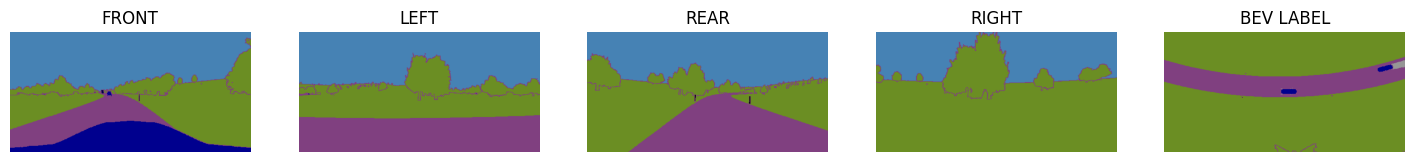

In [8]:
fig, axes = plt.subplots(1, 5, figsize= (18, 12))

# plot Input images
for (ax,img,title) in zip(axes.flatten(), inputImages, ['FRONT', 'LEFT', 'REAR', 'RIGHT']):
    rgbImage = utils.one_hot_decode_image(img.detach().numpy(), inputPalette)
    plotImage(ax, rgbImage, title)

# plot label image
bevRgbImg = utils.one_hot_decode_image(bevLabelImg.detach().numpy(), outputPalette)
plotImage(axes.flatten()[-1], bevRgbImg, 'BEV LABEL')
plt.show()

In [9]:
# Create Validation dataset
valInputDirs = [os.path.join(valDir,x) for x in ['front', 'left', 'rear', 'right']]
valLabelDir = os.path.join(valDir, *['bev+occlusion'])
valSet = Cam2BEVDataset(valInputDirs, valLabelDir)
print(f"There are {len(valSet)} validation images")

There are 500 validation images


In [10]:
### CREATE PYTORCH DATALOADERS
from torch.utils.data import DataLoader
trainLoader = DataLoader(trainSet, batch_size=4, shuffle=True, num_workers=2)
valLoader = DataLoader(valSet, batch_size=8, shuffle=True, num_workers=2)

## Model

We're going to use a model called as **UNetXST**. As the name suggests, its a UNet based model, with additional component where
- X stands for extension. The original UNet model was for single image semantic segmentation. Here, its being extended to mutiple images
- ST stands for Spatial Transformers

As with original UNet model, its an Encoder-Decoder architecture. We'll look at encoder module first


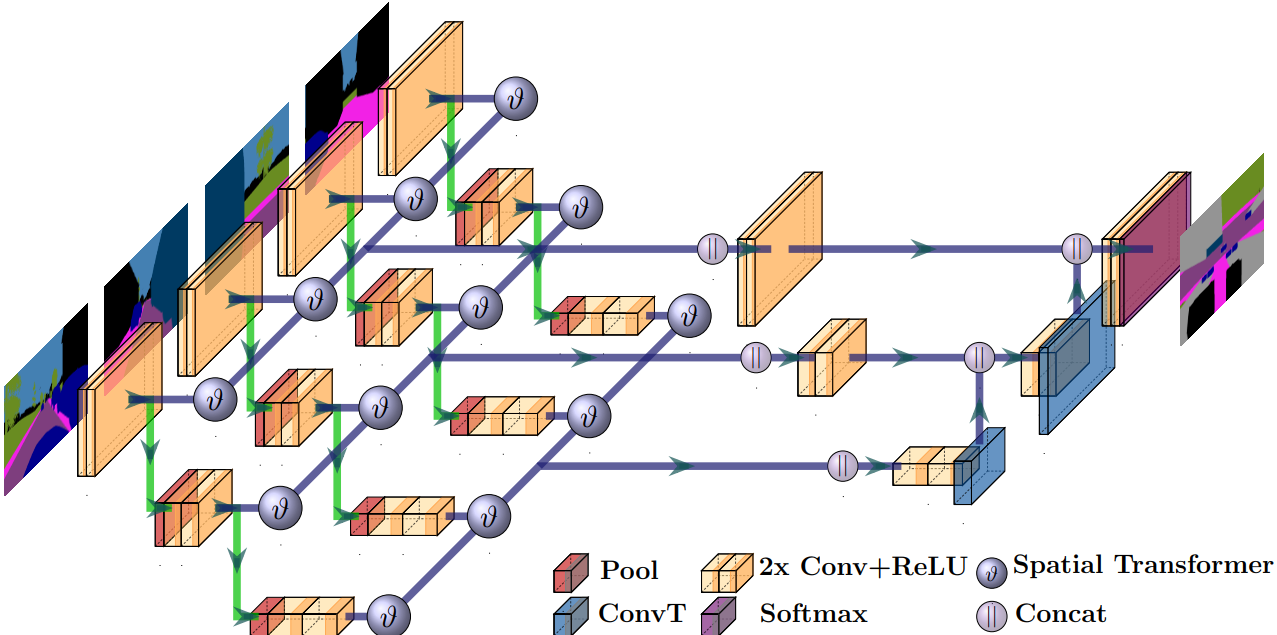

### Encoder
- Model contains a typical Encoder, containing a series of **Convolution and Pooling blocks**, where the image is downsampled number of times
- Same Encoder architecture is applied on all the camera inputs to extract features

In [11]:
class Encoder(nn.Module):
    def __init__(self, inputShape, u_depth, filters1):
        super(Encoder, self).__init__()
        self.u_depth = u_depth
        self.encoder_layers = nn.ModuleList()
        filters = inputShape[-3]
        filters_ = filters1
        for d in range(self.u_depth):
            layer = nn.Sequential(
                nn.Conv2d(filters, filters_, kernel_size=3, padding=1),
                nn.BatchNorm2d(filters_),
                nn.ReLU(True),                
                nn.Conv2d(filters_, filters_, kernel_size=3, padding=1),
                nn.BatchNorm2d(filters_),
                nn.ReLU(True),                
            )
            
            if d<(self.u_depth-1):
                layer.append(nn.MaxPool2d(kernel_size=2, stride=2))
                layer.append(nn.Dropout2d(p=0.1))
            filters = filters_
            filters_ = (2**(d+1))*filters1
            self.encoder_layers.append(layer)

    def forward(self, x):
        encoder_layers = []
        t = x
        for d in range(self.u_depth):
            if d<(self.u_depth-1):
                t = self.encoder_layers[d][:-2](t)
                encoder_layers.append(t)
                t = self.encoder_layers[d][-2:](t)
            else:
                t = self.encoder_layers[d](t)
                encoder_layers.append(t)

        return encoder_layers

In [12]:
encoderModule = Encoder(inputShape=(10,256,512), u_depth=4, filters1=16).to(device)

# Generate sample data, assuming batchsize of 1
singleCameraData = torch.rand(1, 10, 256, 512).to(device)
encoderOutput = encoderModule(singleCameraData)
print(f"Len of encoderOutput = {len(encoderOutput)}")
print(f"Encoder outputs = {[x.shape for x in encoderOutput]}")

Len of encoderOutput = 4
Encoder outputs = [torch.Size([1, 16, 256, 512]), torch.Size([1, 32, 128, 256]), torch.Size([1, 64, 64, 128]), torch.Size([1, 128, 32, 64])]


Each element in encoder is with each depth layer

### Spatial Transformer

[Spatial Transformer Networks](https://browse.arxiv.org/pdf/1506.02025.pdf) are special class of Neural Network, that help CNN architectures be more robust to spatial variations (Rotation, Translation, Shearing etc)

- In this architecture, STN module is used to convert Front facing Image to BEV (Birds Eye View). 
- **The Homography transformation specific to each camera, is fed as input to the STN module**
- STN = Deep Learning variant to achieve in IPM (Inverse Perspective Mapping)
- In ideal case, the transformation parameters will be regressed by the module itself. But that requires long training hours, careful monitoring of loss and regularization. Hence, feeding the reference Homography matrix serves as geometric prior for the model 

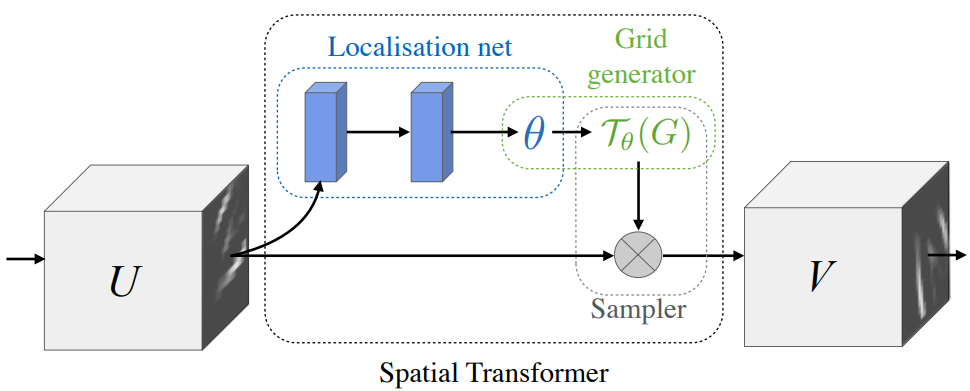

In [13]:
import torchgeometry as tgm
import torch.nn.functional as F

class STN(nn.Module):
    def __init__(self, inputShape, theta):
        super(STN, self).__init__()
        self.theta = theta
        self.warper = tgm.HomographyWarper(inputShape[-2], inputShape[-1])

    def forward(self, x):
        bs = x.shape[0]
        x = self.warper(x, self.theta.repeat(bs,1,1))
        return x

In [14]:
H = [
  np.array([[4.651574574230558e-14, 10.192351107009959, -5.36318723862984e-07], [-5.588661045867985e-07, 0.0, 2.3708767903941617], [35.30731833118676, 0.0, -1.7000018578614013]]),                                       # front
  np.array([[20.38470221401992, 7.562206982469407e-14, -0.28867638384075833], [-3.422067857504854e-23, 2.794330463189411e-07, 2.540225111648729], [2.1619497190382224e-15, -17.65365916559334, -0.4999990710692976]]),    # left    
  np.array([[-5.336674306912119e-14, -10.192351107009957, 5.363187220578325e-07], [5.588660952931949e-07, 3.582264351370481e-23, 2.370876772982613], [-35.30731833118661, -2.263156574813233e-15, -0.5999981421386035]]), # rear
  np.array([[-20.38470221401991, -4.849709834037436e-15, 0.2886763838407495], [-3.4220679184765114e-23, -2.794330512976549e-07, 2.5402251116487626], [2.161949719038217e-15, 17.653659165593304, -0.5000009289306967]])   # right
]

H = [torch.from_numpy(x).float().to(device) for x in H]

In [15]:
stnModule = STN(inputShape=(1,256,512), theta=H[0]).to(device)
stnOutput = stnModule(encoderOutput[0])
print(f"stnOutput shape = {stnOutput.shape}")

stnOutput shape = torch.Size([1, 16, 256, 512])


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


This is all we need to convert a single image to BEV (Birds Eye View). After adding a decoder, we can train the model with BEV image for the single view as label. There is a [Cam2BEV 2F dataset](https://gitlab.ika.rwth-aachen.de/cam2bev/cam2bev-data/-/tree/master/2_F) that contains just the Front facing camera along with corresponding BEV image


### Combine Multiple Images to get 360deg BEV image
We will learn how to combine the **transformed / warped images to get a 360degree BEV**. We'll call it the **Joiner** module. At each level (depth), the joiner module combines the 4 warped images to give a single output image, which is fed to the decoder module 

In [16]:
class Joiner(nn.Module):
    def __init__(self, inputShape, udepth, n_inputs, filters1, returnWarpedOutput=False):
        super(Joiner, self).__init__()
        self.n_inputs = n_inputs
        self.filters1 = filters1
        self.joiner_outputs = []
        self.joiner_layers = nn.ModuleList()
        self.depth_stn_layers = nn.ModuleList()
        self.returnWarpedOutput = returnWarpedOutput  
        
        shape = list(inputShape)
        for d in range(udepth):
            layer = []
            filters = (2**d)*self.filters1
            warped_maps = []
            stn_layers = nn.ModuleList()
            for i in range(self.n_inputs):
                shape[-3] = filters
                shape[-2] = inputShape[-2]//(2**d)
                shape[-1] = inputShape[-1]//(2**d)
                stn_layers.append(STN(tuple(shape), H[i]))

            self.depth_stn_layers.append(stn_layers)
            layer.append(nn.Conv2d(filters*n_inputs, filters, kernel_size=3, padding = 1))
            layer.append(nn.BatchNorm2d(filters))            
            layer.append(nn.ReLU(True))
            layer.append(nn.Conv2d(filters, filters, kernel_size=3, padding = 1))
            layer.append(nn.BatchNorm2d(filters))            
            layer.append(nn.ReLU(True))
            self.joiner_layers.append(nn.Sequential(*layer))
    
    def warpedOutput(self, flag):
        self.returnWarpedOutput = flag
    
    def forward(self, encoder_outputs):
        self.joiner_outputs = []
        warped_outputs = []
        
        for d in range(len(encoder_outputs[0])):
            filters = (2**d)*self.filters1
            warped_maps = []
            for i in range(self.n_inputs):
                t = self.depth_stn_layers[d][i](encoder_outputs[i][d])
                warped_maps.append(t)
            t = torch.cat(warped_maps, dim=1) if self.n_inputs > 1 else warped_maps[0]
            if(self.returnWarpedOutput):
                warped_outputs.append([x.cpu().detach().numpy() for x in warped_maps])            
            t = self.joiner_layers[d](t)
            self.joiner_outputs.append(t)
                
        if(self.returnWarpedOutput):
            return self.joiner_outputs, warped_outputs
        else:
            return self.joiner_outputs

In [17]:
joinerModule = Joiner(inputShape=(10,256,512), udepth=4, n_inputs=4, filters1=16).to(device)
joinerOutput = joinerModule([encoderOutput for i in range(4)])   # simulate inputs from 4 cameras
print(f"Joiner module output = {[x.shape for x in joinerOutput]}")

Joiner module output = [torch.Size([1, 16, 256, 512]), torch.Size([1, 32, 128, 256]), torch.Size([1, 64, 64, 128]), torch.Size([1, 128, 32, 64])]


## Decoder 
The Decoder module is very similar to the UNet with
- Upsampling the lower level's output and concatenating with output from 1 level above
- Skip connection at each level to improve **improved boundaries segmentation**

The only difference being, the **Joiner output is fed to decoder (as it contains multiple images output) instead of Encoder output**

In [18]:
class Decoder(nn.Module):
    def __init__(self, udepth, filters1):
        super(Decoder, self).__init__()
        self.udepth = udepth
        self.filters1 = filters1
        self.decoder_layers = nn.ModuleList()
        
        for d in reversed(range(self.udepth-1)):
            filters = (2**d)*self.filters1
            layer = []
            layer.append(nn.ConvTranspose2d(filters*2, filters, kernel_size=3, stride=2, padding=1, output_padding=1))
            layer.append(nn.Dropout2d(p=0.1))
            layer.append(nn.Conv2d(filters*2, filters, kernel_size=3, padding=1))
            layer.append(nn.BatchNorm2d(filters))            
            layer.append(nn.ReLU(True))
            layer.append(nn.Conv2d(filters, filters, kernel_size=3, padding=1))
            layer.append(nn.BatchNorm2d(filters))            
            layer.append(nn.ReLU(True))
            self.decoder_layers.append(nn.Sequential(*layer))

    def forward(self, joiner_outputs):
        t = joiner_outputs[-1]
        for d in reversed(range(self.udepth-1)):
            filters = (2**d)*self.filters1
            t = self.decoder_layers[self.udepth-2-d][0](t)
            t = torch.cat((joiner_outputs[d], t), dim=1)
            t = self.decoder_layers[self.udepth-2-d][1:](t)
        return t

In [19]:
decoderModule = Decoder(udepth=4, filters1=16).to(device)
decoderOutput = decoderModule(joinerOutput) 
print(f"decoderOutput module output = {decoderOutput.shape}")

decoderOutput module output = torch.Size([1, 16, 256, 512])


### Putting it together - UNetXST

In [20]:
class UNetXST(nn.Module):
    def __init__(self, inputShape, nInputs, nOutputClasses, udepth, filters1, returnWarpedOutput=False):
        super(UNetXST, self).__init__()
        self.inputShape = inputShape        
        self.nInputs = nInputs
        self.nOutputClasses = nOutputClasses
        self.udepth = udepth
        self.filters1 = filters1
        self.returnWarpedOutput = returnWarpedOutput

        self.encoder = nn.ModuleList([Encoder(self.inputShape, self.udepth, self.filters1) for i in range(nInputs)])
        self.joiner = Joiner(self.inputShape, self.udepth, self.nInputs, self.filters1, returnWarpedOutput=self.returnWarpedOutput)
        self.decoder = Decoder(self.udepth, self.filters1)

        self.prediction = nn.Sequential(
            nn.Conv2d(self.filters1, nOutputClasses, kernel_size=3, padding=1),
            nn.Softmax(dim=1)
        )

    def forward(self, inputs):
        encoder_outputs = []
        for i in range(self.nInputs):
            encoder_outputs.append(self.encoder[i](inputs[i]))
            
        if(self.returnWarpedOutput):
            joiner_output, warped_outputs = self.joiner(encoder_outputs)
            decoder_output = self.decoder(joiner_output)
            prediction = self.prediction(decoder_output)
            return prediction, warped_outputs
            
        else:
            joiner_output = self.joiner(encoder_outputs)
            decoder_output = self.decoder(joiner_output)
            prediction = self.prediction(decoder_output)
            return prediction            


In [21]:
model = UNetXST(inputShape =(10, 256, 512), nInputs= 4, nOutputClasses=10, udepth=4, filters1=16).to(device)
print(model)

UNetXST(
  (encoder): ModuleList(
    (0-3): 4 x Encoder(
      (encoder_layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
          (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (7): Dropout2d(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

## Training the model

We'll train the model using the following settings
- **Dice loss function** - as Semantic Segmentation is simply pixel-wise Classification
- **meanIoU Metric** - Mean Intersection over Union
- **Adam Optimizer** - converges faster and often, very good baseline
- **One Cycle LR** learning rate scheduler

We'll train some helper functions / classes to train, validate the model

In [22]:
def plot_training_results(df, model_name):
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.set_ylabel('trainLoss', color='tab:red')
    ax1.plot(df['epoch'].values, df['trainLoss'].values, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('validationLoss', color='tab:blue')
    ax2.plot(df['epoch'].values, df['validationLoss'].values, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.suptitle(f'{model_name} Training, Validation Curves')
    plt.show()

In [23]:
class meanIoU:
    """ Class to find the mean IoU using confusion matrix approach """    
    def __init__(self, num_classes):
        self.iou_metric = 0.0
        self.num_classes = num_classes
        # placeholder for confusion matrix on entire dataset
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

    def update(self, y_preds, labels):
        predicted_labels = torch.argmax(y_preds, dim=1)
        batch_confusion_matrix = self._fast_hist(labels.numpy().flatten(), predicted_labels.numpy().flatten())
        self.confusion_matrix += batch_confusion_matrix
    
    def _fast_hist(self, label_true, label_pred):
        mask = (label_true >= 0) & (label_true < self.num_classes)
        hist = np.bincount(
            self.num_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.num_classes ** 2,
        ).reshape(self.num_classes, self.num_classes)
        return hist

    def compute(self):
        hist = self.confusion_matrix
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        return mean_iu

    def reset(self):
        self.iou_metric = 0.0
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

In [24]:
def evaluate_model(model, dataloader, criterion, metric_class, device):
    model.eval()
    total_loss = 0.0
    metric_object = metric_class(NUM_CLASSES)

    with torch.no_grad():
        for inputs,labels in tqdm(dataloader, total=len(dataloader)):
            inputs = [x.to(device) for x in inputs]
            labels = labels.to(device)            
            _, labels = labels.max(dim=1) # converting to single channel output
            y_preds = model(inputs)

            # calculate loss
            loss = criterion(y_preds, labels)
            total_loss += loss.item()

            # update batch metric information            
            metric_object.update(y_preds.cpu().detach(), labels.cpu().detach())

    evaluation_loss = total_loss / len(dataloader)
    evaluation_metric = metric_object.compute()
    return evaluation_loss, evaluation_metric

In [25]:
import pandas as pd
from tqdm import tqdm

def train_validate_model(model, num_epochs, model_name, criterion, optimizer, 
                         device, dataloader_train, dataloader_valid, 
                         metric_class, metric_name, lr_scheduler = None):
    # initialize placeholders for running values
    results = []    
    min_val_loss = np.Inf
    len_train_loader = len(dataloader_train)

    # move model to device
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        train_loss = 0.0
        for inputs,labels in tqdm(dataloader_train, total=len_train_loader):
            inputs = [x.to(device) for x in inputs]
            labels = labels.to(device)            
            _, labels = labels.max(dim=1) # converting to single channel output
            
            # Forward pass
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
            train_loss += loss.item()
              
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # adjust learning rate
            if lr_scheduler is not None:
                lr_scheduler.step()
            
        # compute per batch losses, metric value
        train_loss = train_loss / len(dataloader_train)
        validation_loss, validation_metric = evaluate_model(
                        model, dataloader_valid, criterion, metric_class, device)

        print(f'Epoch: {epoch+1}, trainLoss:{train_loss:6.5f}, validationLoss:{validation_loss:6.5f}, {metric_name}:{validation_metric: 4.2f}')
        
        # store results
        results.append({'epoch': epoch, 'trainLoss': train_loss, 'validationLoss': validation_loss, f'{metric_name}': validation_metric})
        
        # if validation loss has decreased, save model and reset variable
        if validation_loss <= min_val_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), f"{model_name}.pt")

    # plot results
    results = pd.DataFrame(results)
    plot_training_results(results, model_name)
    return results

In [26]:
# # each entry is % of class in entre training dataset
# bevClassDist = np.array([0.3556033468246461, 0.08613118267059312, 1.3116836547851552e-05,
#                          0.006396475791931152, 0.0007524662017822255, 0.0002047157287597655,
#                          5.084991455078126e-06, 0.10540112304687486, 0.38432099819183363,
#                          0.0611714897155762])

# # Class count -> Normalize weights
# weights = 1 / np.log(1.02 +  bevClassDist)
# normalizedWeights = (weights / np.sum(weights)).astype(np.float32)
# normalizedWeights = torch.from_numpy(normalizedWeights).to(device)

weights = np.array([0.98684351, 2.2481491, 10.47452063, 4.78351389, 7.01028204, 8.41360361, 10.91633349, 2.38571558, 1.02473193, 2.79359197])
normalizedWeights = (weights / np.sum(weights))
normalizedWeights = torch.from_numpy(normalizedWeights).float().to(device)

Starting 1 epoch ...


  0%|          | 0/2000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|██████████| 63/63 [00:32<00:00,  1.96it/s]
/tmp/ipykernel_27/362805843.py:24: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


Epoch: 1, trainLoss:1.68318, validationLoss:1.58265, meanIoU: 0.25
Starting 2 epoch ...


100%|██████████| 63/63 [00:31<00:00,  1.97it/s]


Epoch: 2, trainLoss:1.62149, validationLoss:1.56800, meanIoU: 0.26
Starting 3 epoch ...


100%|██████████| 63/63 [00:31<00:00,  1.97it/s]


Epoch: 3, trainLoss:1.60100, validationLoss:1.56090, meanIoU: 0.27
Starting 4 epoch ...


100%|██████████| 63/63 [00:31<00:00,  1.98it/s]


Epoch: 4, trainLoss:1.58423, validationLoss:1.54665, meanIoU: 0.32
Starting 5 epoch ...


100%|██████████| 63/63 [00:30<00:00,  2.04it/s]


Epoch: 5, trainLoss:1.57477, validationLoss:1.54286, meanIoU: 0.32
Starting 6 epoch ...


100%|██████████| 63/63 [00:31<00:00,  1.98it/s]


Epoch: 6, trainLoss:1.57675, validationLoss:1.54542, meanIoU: 0.32
Starting 7 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.92it/s]


Epoch: 7, trainLoss:1.57509, validationLoss:1.54104, meanIoU: 0.32
Starting 8 epoch ...


100%|██████████| 63/63 [00:31<00:00,  1.99it/s]


Epoch: 8, trainLoss:1.57017, validationLoss:1.54057, meanIoU: 0.32
Starting 9 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.94it/s]


Epoch: 9, trainLoss:1.56486, validationLoss:1.53800, meanIoU: 0.32
Starting 10 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.96it/s]


Epoch: 10, trainLoss:1.56020, validationLoss:1.53632, meanIoU: 0.32
Starting 11 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.96it/s]


Epoch: 11, trainLoss:1.55683, validationLoss:1.53582, meanIoU: 0.33
Starting 12 epoch ...


100%|██████████| 63/63 [00:31<00:00,  1.99it/s]


Epoch: 12, trainLoss:1.56444, validationLoss:1.53760, meanIoU: 0.32
Starting 13 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.95it/s]


Epoch: 13, trainLoss:1.55691, validationLoss:1.53016, meanIoU: 0.34
Starting 14 epoch ...


100%|██████████| 63/63 [00:31<00:00,  2.01it/s]


Epoch: 14, trainLoss:1.55015, validationLoss:1.52909, meanIoU: 0.34
Starting 15 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.93it/s]


Epoch: 15, trainLoss:1.54608, validationLoss:1.52823, meanIoU: 0.34
Starting 16 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.94it/s]


Epoch: 16, trainLoss:1.54279, validationLoss:1.52680, meanIoU: 0.34
Starting 17 epoch ...


100%|██████████| 63/63 [00:33<00:00,  1.85it/s]


Epoch: 17, trainLoss:1.54477, validationLoss:1.52955, meanIoU: 0.34
Starting 18 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.92it/s]


Epoch: 18, trainLoss:1.54701, validationLoss:1.52665, meanIoU: 0.34
Starting 19 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.93it/s]


Epoch: 19, trainLoss:1.54405, validationLoss:1.52603, meanIoU: 0.34
Starting 20 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.93it/s]


Epoch: 20, trainLoss:1.54019, validationLoss:1.52412, meanIoU: 0.35
Starting 21 epoch ...


100%|██████████| 63/63 [00:33<00:00,  1.90it/s]


Epoch: 21, trainLoss:1.53739, validationLoss:1.52542, meanIoU: 0.35
Starting 22 epoch ...


100%|██████████| 63/63 [00:31<00:00,  2.01it/s]


Epoch: 22, trainLoss:1.53524, validationLoss:1.52353, meanIoU: 0.35
Starting 23 epoch ...


100%|██████████| 63/63 [00:33<00:00,  1.88it/s]


Epoch: 23, trainLoss:1.54156, validationLoss:1.52592, meanIoU: 0.34
Starting 24 epoch ...


100%|██████████| 63/63 [00:31<00:00,  2.02it/s]


Epoch: 24, trainLoss:1.53978, validationLoss:1.52517, meanIoU: 0.34
Starting 25 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.94it/s]


Epoch: 25, trainLoss:1.53651, validationLoss:1.52357, meanIoU: 0.35
Starting 26 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.92it/s]


Epoch: 26, trainLoss:1.53361, validationLoss:1.52393, meanIoU: 0.34
Starting 27 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.91it/s]


Epoch: 27, trainLoss:1.53119, validationLoss:1.52241, meanIoU: 0.35
Starting 28 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.95it/s]


Epoch: 28, trainLoss:1.53386, validationLoss:1.52457, meanIoU: 0.35
Starting 29 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.91it/s]


Epoch: 29, trainLoss:1.53620, validationLoss:1.52365, meanIoU: 0.35
Starting 30 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.91it/s]


Epoch: 30, trainLoss:1.53344, validationLoss:1.52471, meanIoU: 0.35
Starting 31 epoch ...


100%|██████████| 63/63 [00:31<00:00,  2.02it/s]


Epoch: 31, trainLoss:1.53098, validationLoss:1.52203, meanIoU: 0.35
Starting 32 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.95it/s]


Epoch: 32, trainLoss:1.52827, validationLoss:1.52199, meanIoU: 0.35
Starting 33 epoch ...


100%|██████████| 63/63 [00:33<00:00,  1.86it/s]


Epoch: 33, trainLoss:1.52655, validationLoss:1.52111, meanIoU: 0.35
Starting 34 epoch ...


100%|██████████| 63/63 [00:33<00:00,  1.89it/s]


Epoch: 34, trainLoss:1.53289, validationLoss:1.52345, meanIoU: 0.35
Starting 35 epoch ...


100%|██████████| 63/63 [00:33<00:00,  1.86it/s]


Epoch: 35, trainLoss:1.53111, validationLoss:1.52188, meanIoU: 0.35
Starting 36 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.91it/s]


Epoch: 36, trainLoss:1.52845, validationLoss:1.52240, meanIoU: 0.35
Starting 37 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.93it/s]


Epoch: 37, trainLoss:1.52621, validationLoss:1.52043, meanIoU: 0.36
Starting 38 epoch ...


100%|██████████| 63/63 [00:31<00:00,  1.98it/s]


Epoch: 38, trainLoss:1.52409, validationLoss:1.52062, meanIoU: 0.35
Starting 39 epoch ...


100%|██████████| 63/63 [00:34<00:00,  1.84it/s]


Epoch: 39, trainLoss:1.52686, validationLoss:1.52287, meanIoU: 0.35
Starting 40 epoch ...


100%|██████████| 63/63 [00:33<00:00,  1.91it/s]


Epoch: 40, trainLoss:1.52911, validationLoss:1.52221, meanIoU: 0.35
Starting 41 epoch ...


100%|██████████| 63/63 [00:31<00:00,  1.97it/s]


Epoch: 41, trainLoss:1.52706, validationLoss:1.52131, meanIoU: 0.35
Starting 42 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.92it/s]


Epoch: 42, trainLoss:1.52455, validationLoss:1.52077, meanIoU: 0.35
Starting 43 epoch ...


100%|██████████| 63/63 [00:33<00:00,  1.91it/s]


Epoch: 43, trainLoss:1.52244, validationLoss:1.52003, meanIoU: 0.36
Starting 44 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.94it/s]


Epoch: 44, trainLoss:1.52076, validationLoss:1.51975, meanIoU: 0.36
Starting 45 epoch ...


100%|██████████| 63/63 [00:33<00:00,  1.87it/s]


Epoch: 45, trainLoss:1.52703, validationLoss:1.52126, meanIoU: 0.36
Starting 46 epoch ...


100%|██████████| 63/63 [00:31<00:00,  1.97it/s]


Epoch: 46, trainLoss:1.52539, validationLoss:1.52081, meanIoU: 0.35
Starting 47 epoch ...


100%|██████████| 63/63 [00:33<00:00,  1.86it/s]


Epoch: 47, trainLoss:1.52318, validationLoss:1.52014, meanIoU: 0.36
Starting 48 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.96it/s]


Epoch: 48, trainLoss:1.52098, validationLoss:1.51985, meanIoU: 0.36
Starting 49 epoch ...


100%|██████████| 63/63 [00:33<00:00,  1.90it/s]


Epoch: 49, trainLoss:1.51938, validationLoss:1.51932, meanIoU: 0.36
Starting 50 epoch ...


100%|██████████| 63/63 [00:33<00:00,  1.87it/s]


Epoch: 50, trainLoss:1.52116, validationLoss:1.52229, meanIoU: 0.35
Starting 51 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.95it/s]


Epoch: 51, trainLoss:1.52421, validationLoss:1.52082, meanIoU: 0.35
Starting 52 epoch ...


100%|██████████| 63/63 [00:30<00:00,  2.08it/s]


Epoch: 52, trainLoss:1.52210, validationLoss:1.51924, meanIoU: 0.36
Starting 53 epoch ...


100%|██████████| 63/63 [00:32<00:00,  1.92it/s]


Epoch: 53, trainLoss:1.52002, validationLoss:1.51947, meanIoU: 0.36
Starting 54 epoch ...


100%|██████████| 63/63 [00:33<00:00,  1.89it/s]


Epoch: 54, trainLoss:1.51819, validationLoss:1.51894, meanIoU: 0.36
Starting 55 epoch ...


100%|██████████| 63/63 [00:30<00:00,  2.03it/s]


Epoch: 55, trainLoss:1.51677, validationLoss:1.51822, meanIoU: 0.36


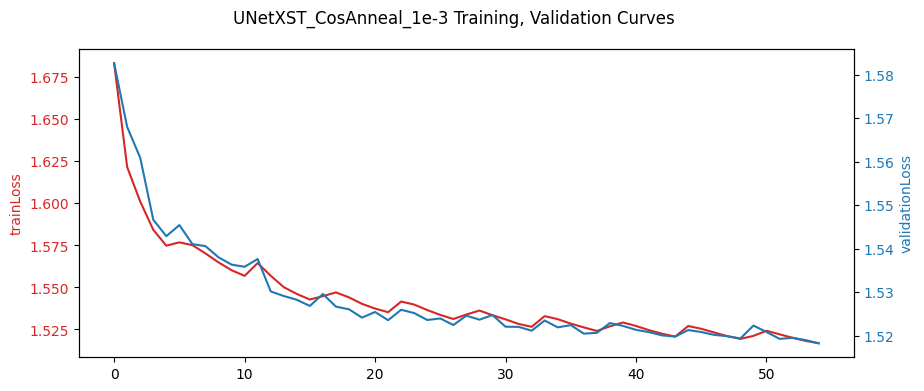

In [27]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts

# reference : https://smp.readthedocs.io/en/latest/losses.html
# criterion = smp.losses.DiceLoss('multiclass', classes=np.arange(10).tolist(), log_loss = True, smooth=1.0)
criterion = nn.CrossEntropyLoss(weight=normalizedWeights)

# MODEL HYPERPARAMETERS
N_EPOCHS = 55
NUM_CLASSES = 10
MAX_LR = 1e-3
MODEL_NAME = 'UNetXST_CosAnneal_1e-3'

# create model, optimizer, lr_scheduler and pass to training function
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
# scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(trainLoader), 
#                        pct_start=0.3, div_factor=10, anneal_strategy='cos')
# scheduler = None

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0 = int(len(trainLoader) * float(N_EPOCHS)/10), eta_min=3e-4)


_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
                         device, trainLoader, valLoader, meanIoU, 'meanIoU',
                         lr_scheduler = scheduler)

## Visualize Model Predictions

We'll run the model through ordered Validation set, store the predicted semantic images along with input semantic images

In [28]:
# One-hot encoding -> color mapping Decoders
inputDecoder = torch.from_numpy(np.array([x[0] for x in inputPalette])).to(device)
outputDecoder = torch.from_numpy(np.array([x[0] for x in outputPalette])).to(device)

In [29]:
# Placeholder for storing output
output = {}
for view in ['FRONT', 'LEFT', 'REAR', 'RIGHT', 'BEV_PREDS']:
    output[f"{view}"] = []
    
# redefine validation loader, but with shuffle set to False
valLoader = DataLoader(valSet, batch_size=8, shuffle=False, num_workers=2)

with torch.no_grad():
    for inputs,labels in tqdm(valLoader, total=len(valLoader)):
        inputs = [x.to(device) for x in inputs]
        y_preds = model(inputs)
        labels = labels.to(device)
        
        # One-hot encoding -> Class Index -> RGB image based on color map
        decodedInputs = [inputDecoder[torch.argmax(x, dim=1)].cpu().detach().numpy() for x in inputs]
        decodedOutputs = outputDecoder[torch.argmax(y_preds, dim=1)].cpu().detach().numpy()
#         decodedLabels = outputDecoder[torch.argmax(labels, dim=1)].cpu().detach().numpy()
        
        # store each sample output as separate item
        for i in range(decodedInputs[0].shape[0]):
            output['FRONT'].append(decodedInputs[0][i])
            output['LEFT'].append(decodedInputs[1][i])
            output['REAR'].append(decodedInputs[2][i])
            output['RIGHT'].append(decodedInputs[3][i])
            output['BEV_PREDS'].append(decodedOutputs[i])
#             output['BEV_PREDS'].append(decodedLabels[i])

100%|██████████| 63/63 [00:23<00:00,  2.65it/s]


In [30]:
import matplotlib.animation as animation

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

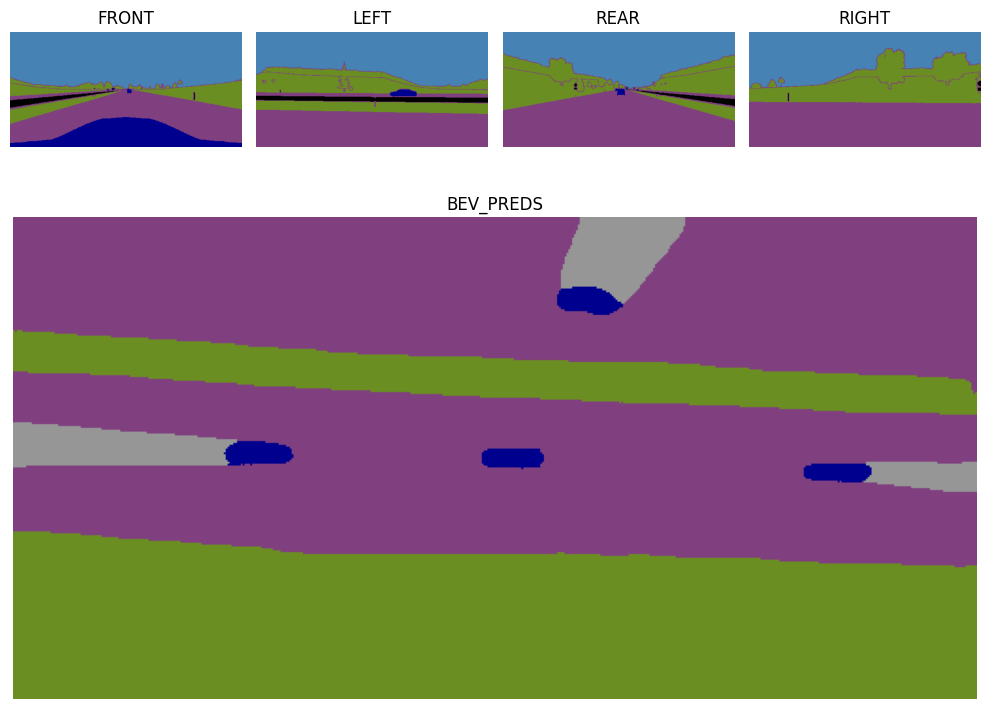

In [31]:
fig, axes = plt.subplot_mosaic([['FRONT', 'LEFT', 'REAR', 'RIGHT'], ['BEV_PREDS', 'BEV_PREDS', 'BEV_PREDS', 'BEV_PREDS']],
                               height_ratios=[0.4, 0.6], figsize=(10, 8))

imgHandles = []
for title,ax in axes.items():
    imgHandles.append(ax.imshow(np.random.rand(256,512)))
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()

def run(index, data, imgHandles):
    for i,view in enumerate(['FRONT', 'LEFT', 'REAR', 'RIGHT', 'BEV_PREDS']):
        imgHandles[i].set_data(output[view][index])
    return imgHandles

ani = animation.FuncAnimation(fig, run, len(output['FRONT']), fargs=(output, imgHandles), blit=True, interval=10, repeat=False)

In [32]:
ani.save('BEV_output.mp4', writer=writer, dpi=100)